## Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import warnings
from pathlib import Path

---
<br>

## Configs

In [5]:
# Filtrando os erros
warnings.filterwarnings('ignore')

# Caminhos para o diretório dos dados
data_path = Path('../01_dados')

# Caminhos para o diretório dos dados
model_path = Path('../04_modelos')

---
<br>

## Funções auxiliares

In [8]:
def grid_search_random_forest(X, y, param_grid, save_path=model_path / 'best_RFC_model.pkl'):
    """
    Realiza uma grid search para RandomForestClassifier e salva o melhor modelo.
    
    Parâmetros:
    - X: array-like, shape (n_samples, n_features). Dados de entrada.
    - y: array-like, shape (n_samples,). Rótulos.
    - param_grid: dict. Grade de hiperparâmetros para buscar.
    - save_path: str. Caminho para salvar o melhor modelo.
    
    Retorna:
    - best_model: O modelo treinado com os melhores parâmetros.
    - best_params: O conjunto de hiperparâmetros que obteve o melhor desempenho.
    """
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Normalizando os dados para que se adeque melhor ao formato esperado pelo treinamento
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Instancia o RandomForestClassifier
    rf = RandomForestClassifier(random_state=42)
    
    # Configura a GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='f1',
        cv=5,  # Validação cruzada com 5 folds
        verbose=2,
        n_jobs=-1
    )
    
    # Treina a GridSearchCV
    print("Iniciando a Grid Search...")
    grid_search.fit(X_train, y_train)
    
    # Recupera o melhor modelo e parâmetros
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Avaliação no conjunto de teste
    print("Avaliação no conjunto de teste:")
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Salva o melhor modelo
    joblib.dump(best_model, save_path)
    print(f"Melhor modelo salvo em: {save_path}")
    
    return best_model, best_params

---
<br>

### 1 Construir um Modelo

#### 1. Pré-processe os dados (tratar valores ausentes, codificar variáveis categóricas).

In [12]:
df = pd.read_csv(data_path / 'titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
df.shape

(891, 12)

In [14]:
# Estatisticas básicas dos dados 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [15]:
# Tipo de dados de cada coluna
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [16]:
# Número de vaslores nulos
column_names = df.columns
for column in column_names:
    print(column + ' - ' + str(df[column].isnull().sum()))

PassengerId - 0
Survived - 0
Pclass - 0
Name - 0
Sex - 0
Age - 177
SibSp - 0
Parch - 0
Ticket - 0
Fare - 0
Cabin - 687
Embarked - 2


**Insights**

- 'Survived' é a coluna/variável alvo.
- 'PassengerId', 'Name' e 'Ticket' não contribuem para a variável alvo 'Survived'. Portanto, podemos removê-las dos dados.
- 'Age' e 'Embarked' possuem poucos valores ausentes. Precisamos imputá-los utilizando diferentes técnicas.
- Como há muitos valores ausentes na coluna 'Cabin', podemos removê-la.
- 'Pclass', 'Sex', 'SibSp', 'Parch' e 'Fare' não possuem valores ausentes.
- Também podemos criar uma nova variável, como 'tamanho total da família', a partir das colunas 'SibSp' e 'Parch'.

In [18]:
# Avalianda a coluna target
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Text(0, 0.5, 'Passenger Count')

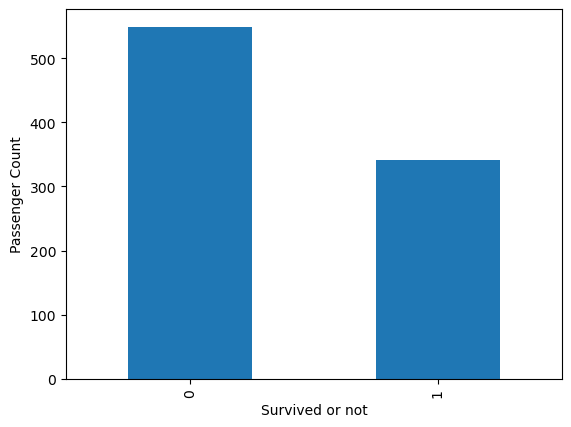

In [19]:
plt = df['Survived'].value_counts(sort=False).plot(kind='bar',)

plt.set_xlabel('Survived or not')
plt.set_ylabel('Passenger Count')

Classes desbalanceadas, cuidados deverão ser tomados na hora da modelagem.
<br>

Criando uma nova variável 'FamilySize' a partir das variáveis 'SibSp'( Quantidade de cônjuges e irmãos a bord) e 'Parch'(Quantidade de pais e filhos a bordo).

In [22]:
# numero de parentes + o indivíduo
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


Criando uma nova variável com a coluna "Name", como sabemos hoje em dia, dados textuais são valiosos, podemos extrair informações dos nomes das pessoas, como por exemplo os títulos.

Depois vamos excluir a coluna nome, uma vez que não agregará mais nenhuma informação.

In [24]:
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df = df.drop(columns='Name')

<Axes: xlabel='Title'>

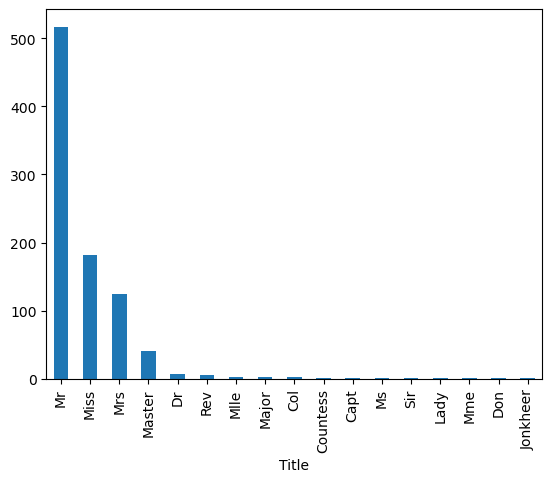

In [25]:
df.Title.value_counts().plot(kind='bar')

vamos combinar os títulos mais raros em "outros" e agregar alguns títulos que foram escritos de formas diferentes.

In [27]:
df['Title'] = df['Title'].replace(['Master', 'Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 'Others')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = df['Title'].replace('Mlle', 'Miss')

In [28]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,Mr


Text(0, 0.5, 'Passenger count')

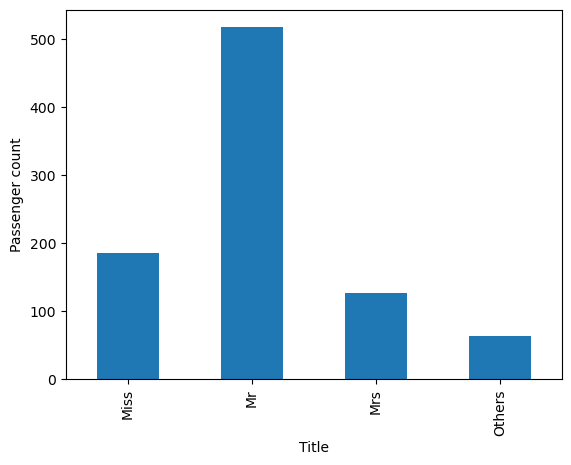

In [29]:
plt = df.Title.value_counts().sort_index().plot(kind='bar')
plt.set_xlabel('Title')
plt.set_ylabel('Passenger count')

Passageiros com o título Mr são a maioria, não iremos tratar fazer mais ajustes pois se plotarmos a probabilidade de cada cada classe sobreviver o Mr será a menor, uma vez que mulheres e crianças foram resgatados primeiro (já conhecia esse dataframe antes, utilizei ele quando estava estudando no início da carreira).

Text(0, 0.5, 'Survival Probability')

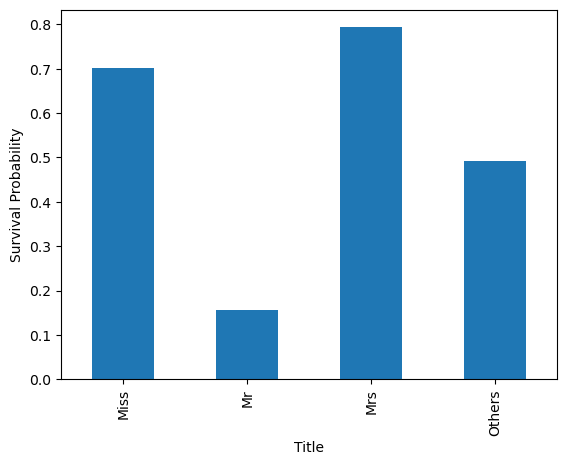

In [31]:
plt = df[['Title', 'Survived']].groupby('Title').mean().Survived.plot(kind= 'bar')
plt.set_xlabel('Title')
plt.set_ylabel('Survival Probability')

In [32]:
# Vamos transformar as classes da coluna títuli em valores numéricos
df['Title'] = df['Title'].map({'Miss':0, 'Mr':1, 'Mrs':2, 'Others':3})

In [33]:
# vamos fazer a mesma coisa para as colunas 'Sex' e 'Embarked'
df['Sex'] = df['Sex'].map({'male':0, 'female':1})
df['Embarked'] = df['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [34]:
# por fim, vamos remover as colunas que não vão grgar informações
df.drop(columns=['Ticket', 'PassengerId', 'Cabin'], axis=1, inplace=True)

In [35]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,0,3,0,22.0,1,0,7.2500,2.0,2,1
1,1,1,1,38.0,1,0,71.2833,0.0,2,2
2,1,3,1,26.0,0,0,7.9250,2.0,1,0
3,1,1,1,35.0,1,0,53.1000,2.0,2,2
4,0,3,0,35.0,0,0,8.0500,2.0,1,1


##### Correlação entre as colunas

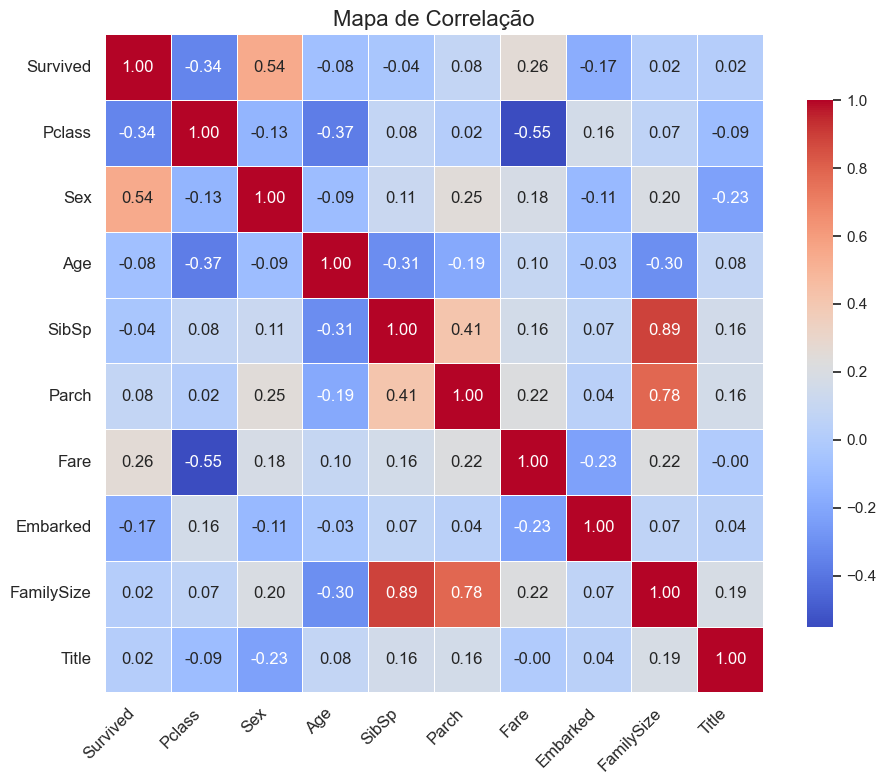

In [37]:
import matplotlib.pyplot as plt

# Calcular a matriz de correlação
correlation_matrix = df.corr()

# Configurar o tamanho e estilo do gráfico
plt.figure(figsize=(10, 8))
sns.set(style="white")

# Criar o mapa de calor
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,  # Mostra os valores dentro dos quadrados
    fmt=".2f",  # Formato dos números
    cmap="coolwarm",  # Paleta de cores
    cbar_kws={"shrink": 0.8},  # Ajusta o tamanho da barra de cores
    linewidths=0.5,  # Linhas entre os quadrados
    square=True  # Quadrados perfeitos
)

# Títulos e ajustes
plt.title("Mapa de Correlação", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()  # Ajusta os elementos para caberem bem na figura

# Mostrar o gráfico
plt.show()

Tirando a coluna que criamos, as outras colunas não são altamente correacionadas, podemos testar uma primeira versão do modelos com todas elas.

Tratando dados missing

In [40]:
df.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Embarked        2
FamilySize      0
Title           0
dtype: int64

In [41]:
# Imputar 'Embarked' com sua classe majoritária. que é "S"
df['Embarked'].fillna(2, inplace=True)

Analisando as variáveis correlacionadas com a idade para tentar prever a idade mais provável possível:

- Age não está correlacionada com 'Sex' e 'Fare'. Portanto, não consideramos essas duas colunas ao imputar 'Age'.
- 'Pclass', 'SibSp' e 'FamilySize' estão negativamente correlacionados com 'Sex'.
- Vamos preencher Age com a idade mediana de linhas semelhantes de 'Pclass', 'SibSp' e 'Parch'. Se não houver linhas semelhantes, preencha a idade com a idade mediana do conjunto total de dados.

In [43]:
# Identifica os índices dos valores NaN na coluna 'Age'
NaN_indexes = df['Age'][df['Age'].isnull()].index

# Itera sobre cada índice onde 'Age' é NaN
for i in NaN_indexes:
    # Tenta prever a idade baseada em outras pessoas com características semelhantes
    # Filtra o DataFrame para encontrar registros com os mesmos valores de:
    # 'SibSp' (número de irmãos ou cônjuges a bordo),
    # 'FamilySize' (tamanho da família a bordo), 
    # 'Pclass' (classe da passagem).
    pred_age = df['Age'][((df.SibSp == df.iloc[i]["SibSp"]) & (df.Parch == df.iloc[i]["FamilySize"]) & (df.Pclass == df.iloc[i]["Pclass"]))].median()
    if not np.isnan(pred_age):
        df['Age'].iloc[i] = pred_age
    else:
        df['Age'].iloc[i] = df['Age'].median()

In [44]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
Title         0
dtype: int64

In [45]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,0,3,0,22.0,1,0,7.2500,2.0,2,1
1,1,1,1,38.0,1,0,71.2833,0.0,2,2
2,1,3,1,26.0,0,0,7.9250,2.0,1,0
3,1,1,1,35.0,1,0,53.1000,2.0,2,2
4,0,3,0,35.0,0,0,8.0500,2.0,1,1


Tudo pronto para etapa de modelagem.

#### 2. Treinando o modelo - 3. Avaliando o modelo

A Função de treinamento será disponibilizada na seção de funções auxiliares, para fins de melhor leitura do código.

In [49]:
X = df.drop(['Survived'], axis=1).values
y = df['Survived'].values

In [50]:
# Define os intervalos dinâmicos para os hiperparâmetros
param_grid = {
    'n_estimators': np.arange(100, 401, 100),       # Varia de 100 a 500 com passos de 100
    'max_depth': np.arange(3, 11, 2).tolist() + [None],  # Varia de 3 a 10 com passos de 10, inclui None
    'min_samples_split': np.arange(2, 15, 3),       # Varia de 2 a 14 com passos de 3
    'min_samples_leaf': np.arange(1, 11, 2),        # Varia de 1 a 10 com passos de 2
    'bootstrap': [True, False]                     # Testa os dois valores de bootstrap
}

In [51]:
best_model, best_params = grid_search_random_forest(X, y, param_grid)

Iniciando a Grid Search...
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Avaliação no conjunto de teste:
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       165
           1       0.83      0.67      0.74       103

    accuracy                           0.82       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268

Melhor modelo salvo em: ..\04_modelos\best_RFC_model.pkl


In [52]:
best_params

{'bootstrap': False,
 'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 400}

---

### 2 Perguntas Conceituais

#### O que são viés e variância em Machine Learning?

Viés e variância são dois conceitos fundamentais em Machine Learning que ajudam a entender os erros de um modelo em relação à sua capacidade de prever novos dados.

#### **Viés**

O **viés** se refere à capacidade de um modelo de capturar os padrões reais dos dados. Um modelo com alto viés é muito simplificado e tem dificuldade em representar a complexidade dos dados, o que pode levar a **underfitting**.

##### Exemplo de um modelo com alto viés
- Um modelo de **regressão linear simples** tentando prever uma relação quadrática, como \( y = x^2 + \epsilon \), onde \( \epsilon \) é o ruído.
  - **Consequência:** O modelo gera previsões lineares que não capturam adequadamente a curva quadrática dos dados, resultando em alto erro tanto no conjunto de treinamento quanto no de validação.

#### **Variância**

A **variância** mede o quão sensível um modelo é a pequenas variações nos dados de treinamento. Um modelo com alta variância tende a ser muito complexo e a se ajustar demais aos dados de treinamento, incluindo ruídos, o que leva a **overfitting**.

##### Exemplo de um modelo com alta variância
- Um modelo de **árvore de decisão sem restrições** tentando prever um conjunto de dados com ruído.
  - **Consequência:** O modelo memoriza os dados de treinamento, incluindo os ruídos, o que resulta em baixo erro no treinamento, mas alto erro nos dados de validação ou teste.


#### **Resumo da relação entre viés e variância**
                                                                            
- **Alta variância**: Modelo muito complexo → Overfitting.

Encontrar um bom modelo em Machine Learning significa equilibrar viés e variância, o que é chamado de **trade-off viés-variância**. Técnicas como **regularização**, **validação cruzada** e ajustes de hiperparâmetros ajudam a mitigar esses problemas.
